In [1]:
import scipy as sp
import numpy as np
import pandas as pd
import timeit
import re
import json
import pickle
import fastparquet
import os
os.chdir('/mnt/t48/bighomes-active/sfeng/patentdiffusion/')
seed = 3
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.iolib.summary2 as summary2

/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
uni_pats = pd.read_pickle("RawData/Cleaned/patent_university_0711.pkl")
# Load data
pdf = fastparquet.ParquetFile("RawData/Cleaned/patent_loc_unique_us_0628.parq").to_pandas()
print(len(pdf))
pdf = pdf.drop_duplicates("patent")
# Remove actual duplicates
dup_pats = pd.read_pickle("RawData/Cleaned/duplicate_pattext_0712.pkl")
pdf = pdf.loc[~(pdf["patent"].isin(dup_pats))]
print(len(pdf))

uni_pats = uni_pats.merge(pdf[["patent", "appyear", "naics_name", "primclass"]], how = "left", on = "patent")
print(len(uni_pats))
# Drop duplicate patent+university
uni_pats = uni_pats.drop_duplicates(["patent", "organization"])
print(len(uni_pats))

2523739
2220706
648332
116182


In [3]:
def get_year_group(x):
    if x in range(1975,1980):
        yg = "1975-80"
    elif x in range(1980,1985):
        yg = "1980-85"
    elif x in range(1985, 1990):
        yg = "1985-90"
    elif x in range(1990,1995):
        yg = "1990-95"
    elif x in range(1995,2000):
        yg = "1995-00"
    elif x in range(2000,2005):
        yg = "2000-05"
    elif x in range(2005,2010):
        yg = "2005-10"
    elif x in range(2010, 2015):
        yg = "2010-15"
    else:
        yg = np.nan
    return yg

pdf["year_group"] = pdf["appyear"].apply(get_year_group)
# Drop missing columns
pdf = pdf.dropna(how="any",subset=["appyear", "naics_name", "primclass", "year_group"])
print(len(pdf))

1525486


## 1. Check if university patents show any change around Bayh Dole

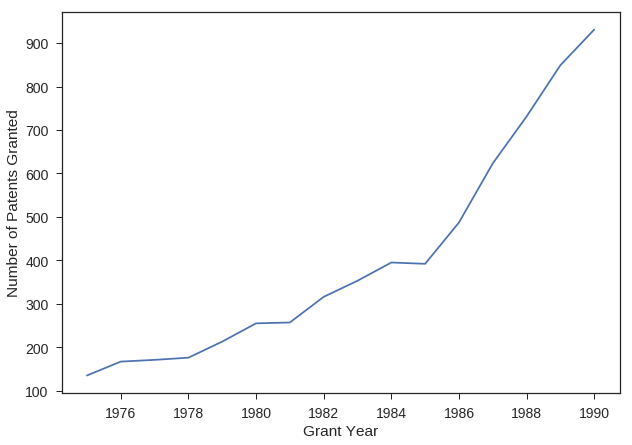

In [4]:
%matplotlib inline
sns.set(font_scale=1.4)
sns.set_style("ticks")
plt.rcParams["font.family"] = "Liberation Sans"
plt.rcParams.update({'font.size': 20})
savepath = "DataStore/2018-07-P3/ResultsGraphs/"

yr_min = 1975
yr_max = 1990

num_u = uni_pats.loc[uni_pats["appyear"].isin(range(yr_min, yr_max+1)), "appyear"].value_counts().sort_index()
fig, ax = plt.subplots(figsize=(10,7))
num_u.plot.line(ax = ax)
ax.set_xlabel("Grant Year")
ax.set_ylabel("Number of Patents Granted")

# plt.savefig(savepath+"2a-UniPatSize.png")
plt.show()


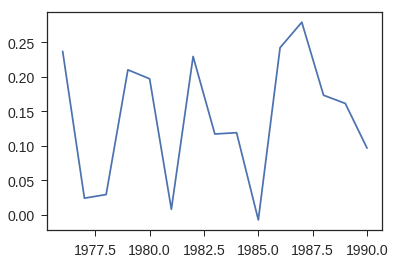

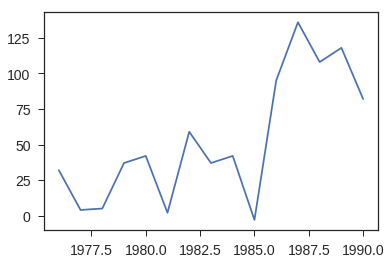

In [5]:
%matplotlib inline
num_u_chg = num_u.pct_change()
num_u_chg.plot.line()
plt.show()
num_u.diff().plot.line()
plt.show()

In [6]:
num_u

1975.0    135
1976.0    167
1977.0    171
1978.0    176
1979.0    213
1980.0    255
1981.0    257
1982.0    316
1983.0    353
1984.0    395
1985.0    392
1986.0    487
1987.0    623
1988.0    731
1989.0    849
1990.0    931
Name: appyear, dtype: int64

In [16]:
# Number of total patents in this time period
len(pdf.loc[pdf["appyear"].isin(range(yr_min, yr_max+1)), "appyear"])

459986

## 2. Location measures
### 2.1. Location distributions of new patents at each year

In [7]:
mc = "msaname"
p3 = uni_pats.loc[uni_pats["appyear"].isin(range(yr_min, yr_max+1))]
ploc = p3[[mc, "appyear", "patent"]].groupby([mc, "appyear"]).count().reset_index()
# Only use those places with greater than 10 patents
ploc = ploc.pivot(index="appyear", columns=mc, values="patent").fillna(0)

# Get proportions
ploc = ploc.apply(lambda x: x/x.sum(), axis=1)

# Delete rows that average less than 1%
ploc = ploc[ploc.columns[ploc.apply(lambda x: x.mean()>0.01, axis=0)]]

# Reapply proportions
ploc = ploc.apply(lambda x: x/x.sum(), axis=1)

# Get number of cities
print(len(ploc.columns))

19


In [8]:
sim = 1-sp.spatial.distance.cdist(ploc.values,ploc.values,metric="cosine")
# Make dataframe
sim = pd.DataFrame(sim, columns=list(range(yr_min,yr_max+1)), index=list(range(yr_min,yr_max+1))).unstack().reset_index()
sim.columns=["appyear1", "appyear2", "sim_location"]
sim["lag"] = sim["appyear2"]-sim["appyear1"]

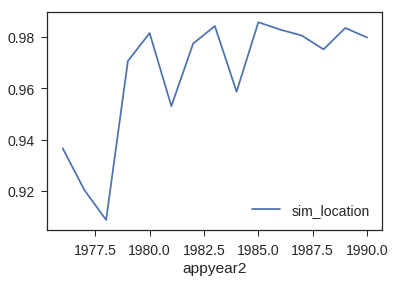

In [9]:
%matplotlib inline
# Plot
sim1 = sim.loc[sim["lag"] == 1, ["appyear2", "sim_location"]].set_index("appyear2")
sim1.plot.line()

In [10]:
act = ploc.loc[[1978,1979]].T
act["Diff"] = act[1979]-act[1978]
act.sort_values("Diff", ascending=False)

appyear,1978,1979,Diff
msaname,,,
"Houston-Sugar Land-Baytown, TX",0.014815,0.058140,0.043325
"New York-Northern New Jersey-Long Island, NY-NJ-PA",0.237037,0.273256,0.036219
"Lexington-Fayette, KY",0.022222,0.034884,0.012661
"Salt Lake City, UT",0.007407,0.017442,0.010034
"Minneapolis-St. Paul-Bloomington, MN-WI",0.044444,0.052326,0.007881
"Tampa-St. Petersburg-Clearwater, FL",0.000000,0.005814,0.005814
"Detroit-Warren-Livonia, MI",0.007407,0.011628,0.004220
"Knoxville, TN",0.007407,0.011628,0.004220
"Chicago-Joliet-Naperville, IL-IN-WI",0.044444,0.046512,0.002067


In [11]:
uni_79 = pd.concat([p3.loc[p3["appyear"] == 1978, "organization"].value_counts(),
                   p3.loc[p3["appyear"] == 1979, "organization"].value_counts()], axis=1)
uni_79.columns = [1978,1979]
uni_79["Diff"] = uni_79[1979]-uni_79[1978]
uni_79.sort_values("Diff", ascending=False)[:10]

,1978,1979,Diff
THE REGENTS OF THE UNIVERSITY OF CALIFORNIA,19.0,34.0,15.0
UNIVERSITY OF DELAWARE,5.0,12.0,7.0
REGENTS OF THE UNIVERSITY OF MINNESOTA,6.0,9.0,3.0
THE TRUSTEES OF BOSTON UNIVERSITY,1.0,4.0,3.0
"IOWA STATE UNIVERSITY RESEARCH FOUNDATION, INC.",10.0,13.0,3.0
UNIVERSITY OF KENTUCKY RESEARCH FOUNDATION,3.0,6.0,3.0
UNIVERSITY OF MIAMI,2.0,4.0,2.0
THE UNIVERSITY OF ILLINOIS FOUNDATION,6.0,8.0,2.0
BOARD OF CONTROL OF MICHIGAN TECHNOLOGICAL UNIVERSITY,3.0,4.0,1.0
UNIVERSITY OF ROCHESTER,5.0,6.0,1.0


### 2.2 HHI

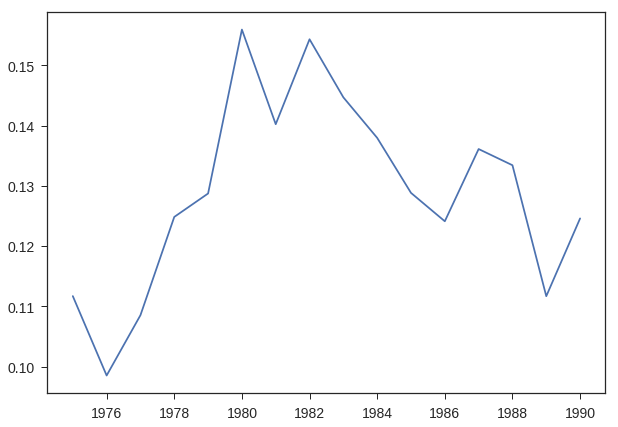

In [15]:
%matplotlib inline
# Plot
fig, ax = plt.subplots(figsize=(10,7))
hhi = pd.Series(np.sum(ploc.values**2,axis=1), index = list(range(yr_min,yr_max+1)))
hhi.plot.line()

______

## 2. Bayh-Dole Sample

1. Get selected industries
2. Get university sample and sample of other patents in the same industries, get their relevant info
3. Add variables
4. Group each in target by MSA, c
5. Group relevant patents p_rel by MSA,c and also by c
6. Sample min len(g), 10 from each

In [44]:
c = "naics_name"
k = "year_group"
m = "inv_msa"
yr_min = 1975
yr_max = 1990

# Get uni patent industries
uni_naics = uni_pats.loc[uni_pats["appyear"].isin(range(1978,1982)), "naics_name"].value_counts()
uni_naics = uni_naics[uni_naics>100]

uni2 = pdf.loc[pdf[c].isin(uni_naics.index) & pdf["patent"].isin(uni_pats["patent"]) \
               & (pdf["appyear"].isin(range(yr_min, yr_max))),
              ["patent", "inv_msa", "appyear", "year_group", "naics_name", "primclass"]].copy().reset_index(drop=True)
uni2["tp_is_uni"] = True
p_rel = pdf.loc[pdf[c].isin(uni_naics.index) & (pdf["appyear"].isin(range(yr_min, yr_max))), uni2.columns]
p2 = p_rel.sample(frac=0.2).reset_index(drop=True)
p2["tp_is_uni"] = False
targ = uni2.append(p2, ignore_index=True).reset_index(drop=True)
del(p2, uni2)

/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [52]:
targ_g = targ.groupby([c,k,m]) # Each group is from same field, MSA, year group
p_c_m = p_rel.groupby([c,k,m]) # Each group is from same field, MSA, year group
p_c = p_rel.groupby([c,k]) # Each group from the same field, year group
ts = pd.DataFrame()
for n,g in targ_g:
    # Propagate the target patents
    # Get num x existing patent lists and randomize them
    num = 20
    p_all = []
    for i in range(num):
        p_all.extend(g["patent"].tolist())
    tp_in_msa = p_all
    if n in p_c_m.groups.keys():
        op_in_msa = p_c_m.get_group(n)["patent"].sample(n=len(tp_in_msa), replace=True).tolist()
        in_msa = pd.DataFrame({"tp": tp_in_msa, "op": op_in_msa})
        in_msa["samp"] = "In MSA"
    else:
        in_msa = pd.DataFrame()
    if (n[0], n[1]) in p_c.groups.keys():
        op_in_field = p_c.get_group((n[0], n[1]))["patent"].sample(n=len(tp_in_msa), replace=True).tolist()
        in_field = pd.DataFrame({"tp": tp_in_msa, "op": op_in_field})
        in_field["samp"] = "In Field"
    else:
        in_field = pd.DataFrame()   
    
    # Merge
    samp = pd.concat([in_msa, in_field], axis=0)
    if len(samp) > 0:
        # Remove where other is less than target
        samp = samp.loc[(samp["tp"] < samp["op"])]
        ts = ts.append(samp, ignore_index = True)

print(len(ts))

In [54]:
asgs = pickle.load(open("RawData/Cleaned/patent_assignee_dict_0628.pkl", "rb"))
# Check that target and other do not have same assignee
%time asg_match = (set(asgs.get(tp, [])).intersection(asgs.get(op, [])) for tp, op in zip(ts["tp"], ts["op"]))
%time asg_match = [len(i) for i in asg_match]

ts["asg_match"] = asg_match
ts = ts.loc[ts["asg_match"] == 0]
ts = ts.drop("asg_match",1)
print(len(ts))
del(asgs)

CPU times: user 24.6 ms, sys: 25.1 ms, total: 49.7 ms
Wall time: 49.5 ms
CPU times: user 1.12 s, sys: 3.04 ms, total: 1.13 s
Wall time: 1.12 s
795781


In [56]:
ts["tp_is_uni"] = ts["tp"].map(dict(zip(targ["patent"],targ["tp_is_uni"])))
ts["op_is_uni"] = ts["op"].map(dict(zip(targ["patent"],targ["tp_is_uni"])))

In [57]:
uni_pats.to_pickle("DataStore/2018-07-P2/UniPats/uni_pats_0722.pkl")
ts.to_pickle("DataStore/2018-07-P2/UniPats/uni_pats_samp_0722.pkl")